# Detecting Fraud in Online E-Commerce Transactions
 
10.02.19

(Data: https://www.kaggle.com/c/ieee-fraud-detection/data)

In this project, I predict the probability that an online e-commerce transaction is fraudulent. I analyze data, engineer features, and compare several classifiers to select the best model. 

The goal is to improve the efficacy of fraudulent transaction alerts, helping businesses reduce their fraud loss and improve customer satisfaction.

Topics:

- Exploratory Data Analysis
- Feature Engineering (including Principal Component Analysis (PCA))
- Class imbalance techniques (Random Undersampling, Synthetic Minority Oversampling Technique (SMOTE))
- Model selection and tuning (Decision Tree, Random Forest Classifier, Gradient Boosting Classifier, GridSearchCV)
- Model evaluation (Area under Receiver Operating Characteristics curve (ROC AUC))

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn import tree, ensemble, metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
import pydotplus
import graphviz

from collections import Counter
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Exploratory Data Analysis and Feature Engineering

The data is broken into two files, "identity" and "transaction." Not all transactions have corresponding identity information. I'll merge the files, conduct univariate and multivariate analysis, and engineer features.

In [2]:
# Read in the data.
df_train_identity = pd.read_csv('train_identity.csv')
df_train_transaction = pd.read_csv('train_transaction.csv')

In [3]:
# Quick review of the data.
print(df_train_transaction.shape)
df_train_transaction.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(df_train_identity.shape)
df_train_identity.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# Merge transaction and identity train data.
df_train = pd.merge(df_train_transaction, df_train_identity,
                    how='left', on='TransactionID')
del df_train_identity, df_train_transaction

# Review the data.
print(df_train.shape)

(590540, 434)


In [6]:
# # Get percentage of missing values.
# df_null = (df_train.isnull().sum()*100/df_train.isnull().count())
# df_null.sort_values(ascending=False)

In [7]:
# Impute missing data in categorical variables.
for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = df_train[i].fillna('missing')

In [8]:
# Review data.
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Target Variable

"isFraud" is a binary variable, so I'll work with classification models. 

The distribution of the classes shows that 3.6% of transactions are labeled as a fraud, and 96.4% of transactions are labeled as normal. Later in the process, I'll use techniques to even out the volume of observations in each class.

In [9]:
# Get percentage of fraudulent transactions.
print(df_train['isFraud'].value_counts())
df_train['isFraud'].value_counts()[1]*100/df_train['isFraud'].value_counts()[0]

0    569877
1     20663
Name: isFraud, dtype: int64


3.625870143908247

Text(0.5, 1.0, 'Normal vs. Fraudulent Transactions')

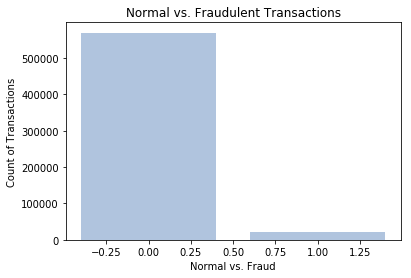

In [10]:
# Plot normal vs. fraudulent transactions:
plt.bar(df_train.groupby('isFraud')['isFraud'].count().index,
         df_train.groupby('isFraud')['isFraud'].count(), color='lightsteelblue')
plt.ylabel('Count of Transactions')
plt.xlabel('Normal vs. Fraud')
plt.title('Normal vs. Fraudulent Transactions')

### Transaction Time Delta
TransactionDT is "timedelta from a given reference datetime (not an actual timestamp)." 

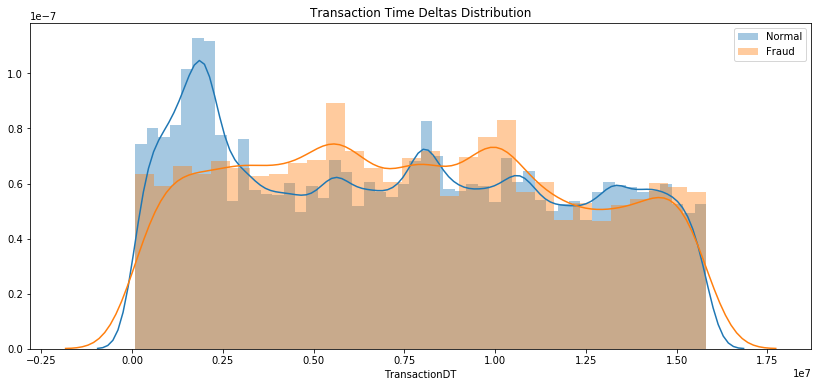

In [11]:
# Plot transaction time delta.
plt.figure(figsize = (14,6))

sns.distplot(df_train.loc[df_train['isFraud'] == 0]['TransactionDT'],kde=True)
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['TransactionDT'],kde=True)
plt.title('Transaction Time Deltas Distribution')
plt.legend(['Normal','Fraud'])
plt.show()

In [12]:
# Test whether group differences are significant.
ttest_ind(df_train[df_train.isFraud == 0][['TransactionDT']],
          df_train[df_train.isFraud == 1][['TransactionDT']])

Ttest_indResult(statistic=array([-10.07009977]), pvalue=array([7.52352445e-24]))

There is a difference in time deltas between normal and fraudulent transactions.

### Transaction Amount
Transaction amount is "transaction payment amount in USD." 

Text(0.5, 1.0, 'Average Transactions Labeled as Normal vs Fraud')

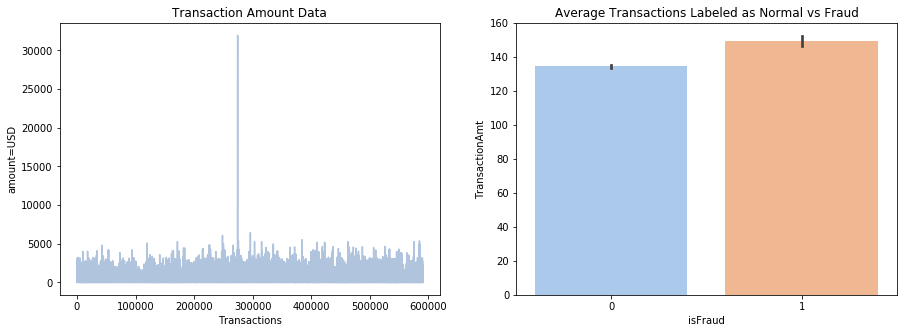

In [13]:
plt.figure(figsize=(15,5))

# Plot transaction amount data.
plt.subplot(1,2,1)
plt.plot(df_train['TransactionAmt'], color='lightsteelblue')
plt.title('Transaction Amount Data')
plt.ylabel('amount=USD')
plt.xlabel('Transactions')

# Plot normal vs. fraudulent transactions.
plt.subplot(1,2,2)
sns.barplot(df_train['isFraud'], df_train['TransactionAmt'],palette='pastel')
plt.title('Average Transactions Labeled as Normal vs Fraud')

In [14]:
# Get mean transaction amount for normal and fraudulent transactions.
df_train[['TransactionAmt','isFraud']].groupby('isFraud').mean()

,TransactionAmt
isFraud,
0,134.511665
1,149.244779


In [15]:
# Test whether group differences are significant.
ttest_ind(df_train[df_train.isFraud == 0][['TransactionAmt']],
          df_train[df_train.isFraud == 1][['TransactionAmt']])

Ttest_indResult(statistic=array([-8.6994436]), pvalue=array([3.34346246e-18]))

In [16]:
# Review transactions over $7,500.
df_train.loc[df_train['TransactionAmt'] > 7500]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing


The distribution plot shows outliers, which are two transactions for \\$31937.391 not labeled as a fraud. I'll limit the value of outliers and use Tukey's method to confirm there are no other outliers.

Average transaction labeled as fraud is higher than average normal transaction (\\$149.2 vs \\$134.5). T-test confirms that the difference is statistically significant. 

The score threshold is: 1.0
Number of outliers is: 91539
The score threshold is: 1.5
Number of outliers is: 66482
The score threshold is: 2.0
Number of outliers is: 55384
The score threshold is: 2.5
Number of outliers is: 45084
The score threshold is: 3.0
Number of outliers is: 36422
The score threshold is: 3.5
Number of outliers is: 32455
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


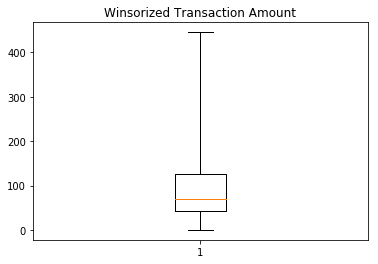

In [17]:
# Limit the value of outliers.
df_train['TransactionAmt'] = winsorize(df_train['TransactionAmt'], (0, 0.05))

# Plot to review if there are outliers.
plt.boxplot(df_train['TransactionAmt'], whis=10)
plt.title('Winsorized Transaction Amount')

# Use Tukey's method to confirm there are no outliers.
q75, q25 = np.percentile(df_train['TransactionAmt'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print('The score threshold is: {}'.format(threshold))
    print('Number of outliers is: {}'.format(
        len((np.where((df_train['TransactionAmt'] > max_val) 
                      | (df_train['TransactionAmt'] < min_val))[0]))
    ))

### Product Code
ProductCD is "product code, the product for each transaction." There are five categories. The meaning of each category is not provided, but there are differences among categories for fraudulent and normal transactions.

ProductCD      C      H      R      S       W
isFraud                                      
0          60511  31450  36273  10942  430701
1           8008   1574   1426    686    8969


Text(0.5, 1.0, 'Normal vs Fraud per Product Code')

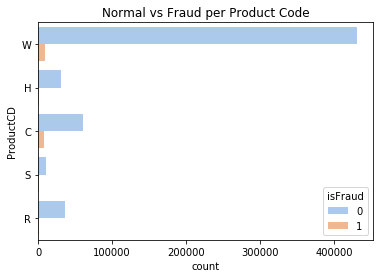

In [18]:
# Review number of normal vs fraudulent transaction based on product code.
count_table = pd.crosstab(df_train['isFraud'], df_train['ProductCD'])
print(count_table)

# Plot counts.
sns.countplot(y=df_train['ProductCD'], hue=df_train['isFraud'], palette='pastel')
plt.title('Normal vs Fraud per Product Code')

In [19]:
# Test if the differences are statistically significant.
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=2656302.643817523, pvalue=0.0)


## Payment Card Information

Variables card1 through card6 are "payment card information, such as card type, card category, issue bank, country, etc." It is stated in the data description that these are categorical variables, so I'll impute missing values using most frequent values in each variable. 

In [20]:
# Review missing values.
for i in df_train.columns:
    if i.startswith('card'):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

card1
0.0
card2
1.5126833068039423
card3
0.26501168422122123
card4
0.0
card5
0.7212043214684865
card6
0.0


In [21]:
# Impute data using mode().
for i in df_train.columns:
    if i.startswith('card'):
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)

There is not much insight into what each variable means. I'll plot the distribution of each to have a quick look at differences in distribution.

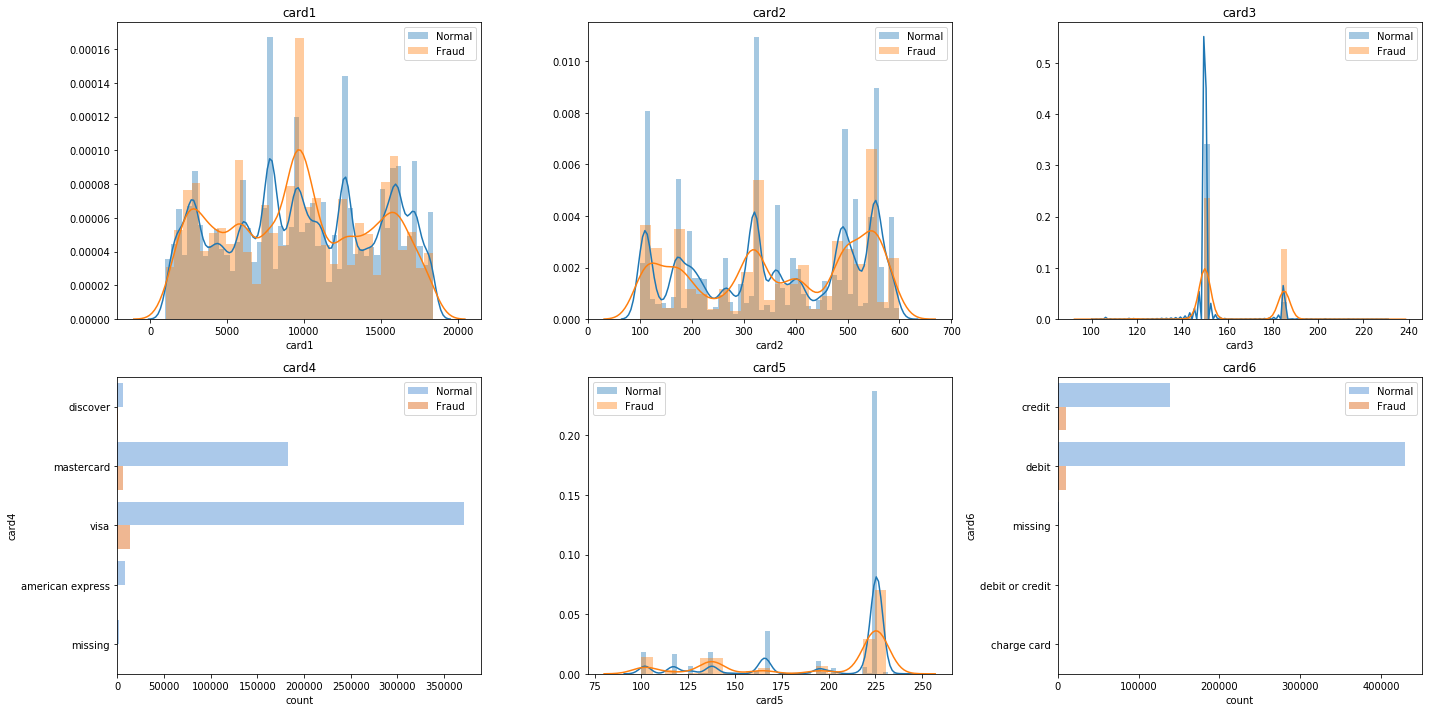

In [22]:
# Plot the variables.
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card1'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card1'])
plt.legend(['Normal','Fraud'])
plt.title('card1')

plt.subplot(2,3,2)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card2'],kde=True)
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card2'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card2')

plt.subplot(2,3,3)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card3'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card3'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card3')

plt.subplot(2,3,4)
sns.countplot(y=df_train['card4'], hue=df_train['isFraud'], palette='pastel')
plt.legend(['Normal','Fraud'])
plt.title('card4')

plt.subplot(2,3,5)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card5'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card5'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card5')

plt.subplot(2,3,6)
sns.countplot(y=df_train['card6'], hue=df_train['isFraud'], palette='pastel')
plt.legend(['Normal','Fraud'])
plt.title('card6')
plt.tight_layout()

## Address

Address variables have about 11% of missing data that I'll impute using mode. Data description states that these are also categorical variables, and there is not much insight into what the numbers mean.

In [23]:
# Review missing values.
for i in df_train.columns:
    if i.startswith('addr'):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

addr1
11.12642666034477
addr2
11.12642666034477


In [24]:
# Impute data by mode given that these are categorical variables.
for i in df_train.columns:
    if i.startswith('addr'):
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)

Text(0.5, 1.0, 'addr2')

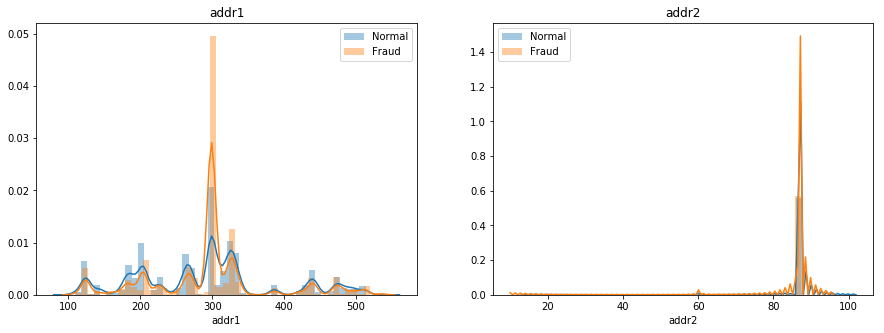

In [25]:
# Plot variables. 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['addr1'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['addr1'])
plt.title('addr1')
plt.legend(['Normal','Fraud'])

plt.subplot(1,2,2)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['addr2'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['addr2'])
plt.legend(['Normal','Fraud'])
plt.title('addr2')

## Distance
dist1 is a  continuous variable with almost 60% of missing values. It has a lot of unique values, so I'll keep the variable and impute missing data using mean.

In [26]:
# Review dist variables.
for i in df_train.columns:
    if i.startswith('dist'):
        #print(i)
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column dist1 are: [  19.   nan  287. ... 4851. 2042. 4728.]
Unique values in column dist2 are: [  nan   30.   98. ... 1467. 1172. 2296.]


In [27]:
# Get percentage of missing values.
df_train['dist1'].isnull().sum()*100/df_train['dist1'].isnull().count()

59.6523520845328

In [28]:
# Impute missing values.
df_train['dist1'].fillna(df_train['dist1'].mean(), inplace=True)

# t-test:
df_train[['dist1','isFraud']].groupby('isFraud').mean()
ttest_ind(df_train[df_train.isFraud == 0][['dist1']],
          df_train[df_train.isFraud == 1][['dist1']])

Ttest_indResult(statistic=array([-7.99592431]), pvalue=array([1.28835029e-15]))

Text(0.5, 1.0, 'Distance')

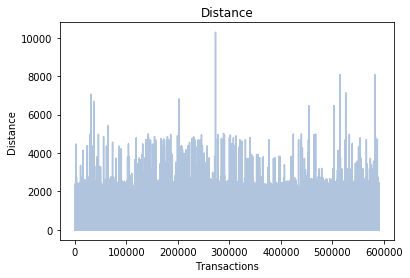

In [29]:
# Plot the distribution of the variable.
plt.plot(df_train['dist1'], color='lightsteelblue')
plt.xlabel('Transactions')
plt.ylabel('Distance')
plt.title('Distance')

### Email domains

P_emaildomain is "purchaser email domain." This variable has many categories with uncommon email domains. I'll engineer a new feature with top email domains and everything else in the "other" category.

['missing' 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com'
 'anonymous.com' 'hotmail.com' 'verizon.net' 'aol.com' 'me.com'
 'comcast.net' 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com'
 'prodigy.net.mx' 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail'
 'live.com' 'att.net' 'juno.com' 'ymail.com' 'sbcglobal.net'
 'bellsouth.net' 'msn.com' 'q.com' 'yahoo.com.mx' 'centurylink.net'
 'servicios-ta.com' 'earthlink.net' 'hotmail.es' 'cfl.rr.com'
 'roadrunner.com' 'netzero.net' 'gmx.de' 'suddenlink.net'
 'frontiernet.net' 'windstream.net' 'frontier.com' 'outlook.es' 'mac.com'
 'netzero.com' 'aim.com' 'web.de' 'twc.com' 'cableone.net' 'yahoo.fr'
 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net' 'live.fr' 'yahoo.co.uk'
 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk' 'protonmail.com' 'yahoo.co.jp']


Text(0.5, 1.0, 'Purchaser Email Domains')

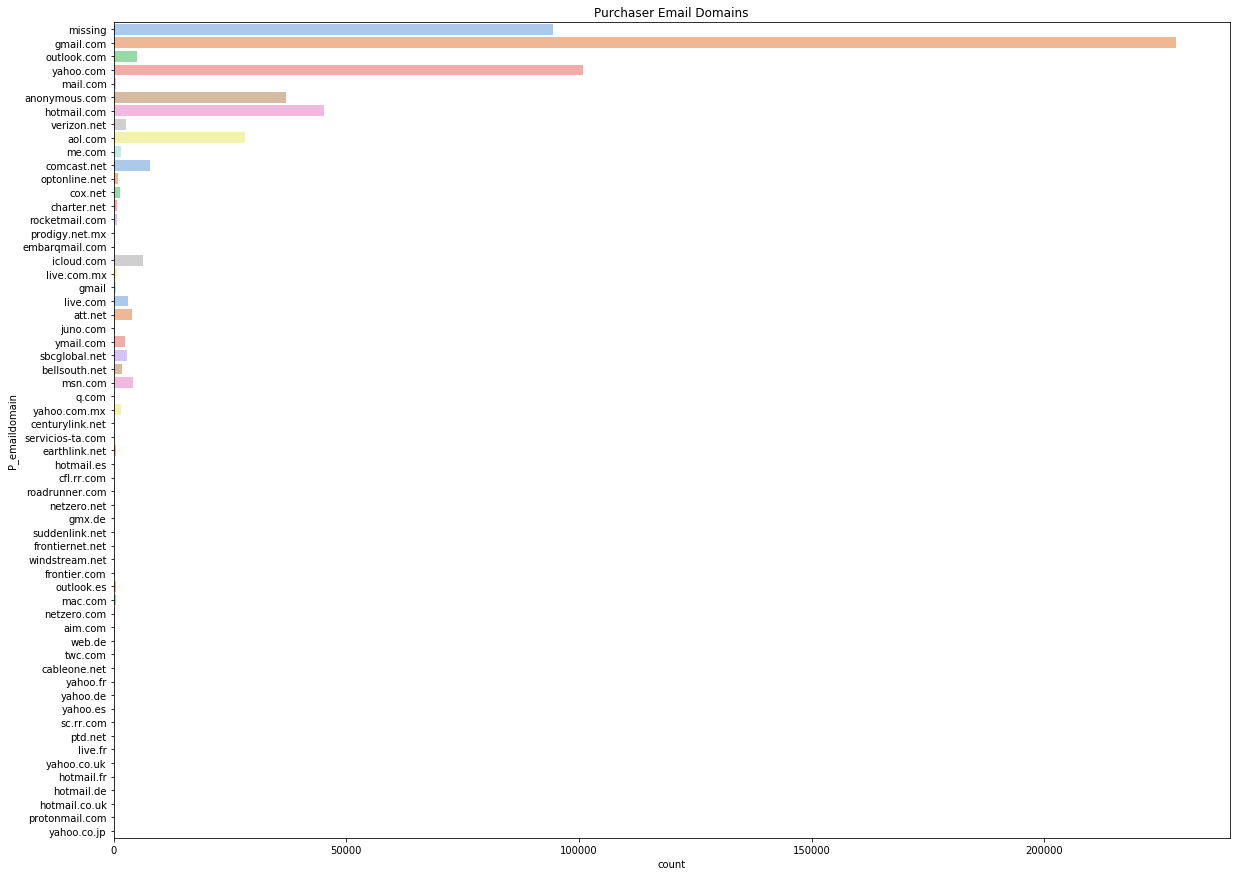

In [30]:
# Review unique values.
print(df_train['P_emaildomain'].unique())

# Plot the counts of values.
plt.figure(figsize=(20,15))
sns.countplot(y=df_train['P_emaildomain'], palette='pastel')
plt.title('Purchaser Email Domains')

Power_divergenceResult(statistic=array([229066.4913534 ,  15408.58563616]), pvalue=array([0., 0.]))


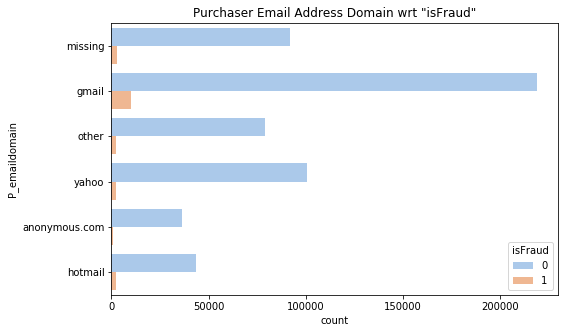

In [31]:
# Engineer new feature.
# De-dupe values such as gmail.com and gmail.
df_train['P_emaildomain']= df_train['P_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

# Create "other" category.
df_train.loc[~df_train.P_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'P_emaildomain'] = 'other'

# Plot the new variable.
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['P_emaildomain'], hue=df_train['isFraud'], palette='pastel')
plt.title('Purchaser Email Address Domain wrt "isFraud"')

# Test group differences.
count_table = pd.crosstab(df_train['P_emaildomain'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

**R_emaildomain** is "recipient email domain." It has similar unique values and about 75% of missing values. 

Power_divergenceResult(statistic=array([1546743.66430124,   20541.76261917]), pvalue=array([0., 0.]))


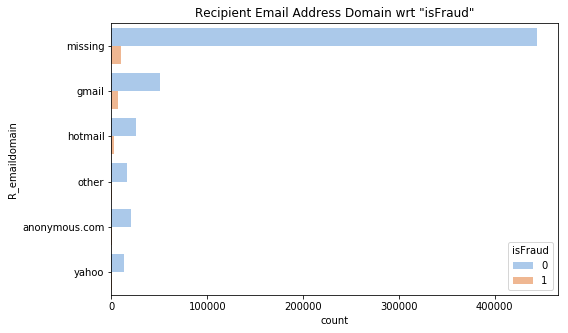

In [32]:
# Engineer new feature.
# De-dupe values such as gmail.com and gmail.
df_train['R_emaildomain']= df_train['R_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

# Create "other" category.
df_train.loc[~df_train.R_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'R_emaildomain'] = 'other'

# Plot the new variable.
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['R_emaildomain'], hue=df_train['isFraud'], palette='pastel')
plt.title('Recipient Email Address Domain wrt "isFraud"')

# Test group differences.
count_table = pd.crosstab(df_train['R_emaildomain'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

## Vesta engineered features
Cxxx, Dxxx, Mxxx, and Vxxx are Vesta-engineered features. Given that the actual meaning is masked, it's unclear how to further engineer these features. I'll impute missing values and reduce the dimensionality of some of these features.

### C1-C14
"counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked."

In [33]:
# Review missing and unique values.
for i in df_train.columns:
    if re.findall(r'^C\d', i):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
# #         print('Unique values in column {} are: {}'
# #           .format(i, df_train[i].unique()))

C1
0.0
C2
0.0
C3
0.0
C4
0.0
C5
0.0
C6
0.0
C7
0.0
C8
0.0
C9
0.0
C10
0.0
C11
0.0
C12
0.0
C13
0.0
C14
0.0


Text(0.5, 1.0, 'Correlation of C Features')

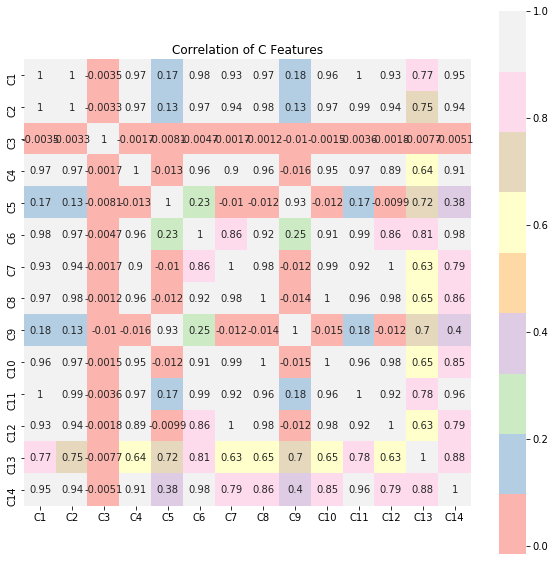

In [34]:
# Review correlation.
plt.figure(figsize=(10,10))

c_check_corr = df_train.filter(regex=('^C\d')).corr()
sns.heatmap(c_check_corr, annot=True, square=True, cmap='Pastel1')
plt.title('Correlation of C Features')

C1-C14 are continuous variables, there are no missing values. Many of these are correlated, which may affect feature importance in tree models.

### D1-D15

"timedelta, such as days between previous transaction, etc."

In [35]:
# Review missing values.
for i in df_train.columns:
    if re.findall(r'^D\d', i):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

D1
0.21488806854743117
D2
47.54919226470688
D3
44.514850814508755
D4
28.604666915026925
D5
52.46740271615809
D6
87.60676668811597
D7
93.40992989467267
D8
87.31229044603245
D9
87.31229044603245
D10
12.873302401192129
D11
47.29349409015477
D12
89.04104717715988
D13
89.50926270870728
D14
89.46946862193924
D15
15.090087038981272


In [36]:
# Impute missing values by getting mean values.
for i in df_train.columns:
    if re.findall(r'^D\d', i):
        df_train[i].fillna(df_train[i].mean(), inplace=True)

Text(0.5, 1.0, 'Correlation of D Features')

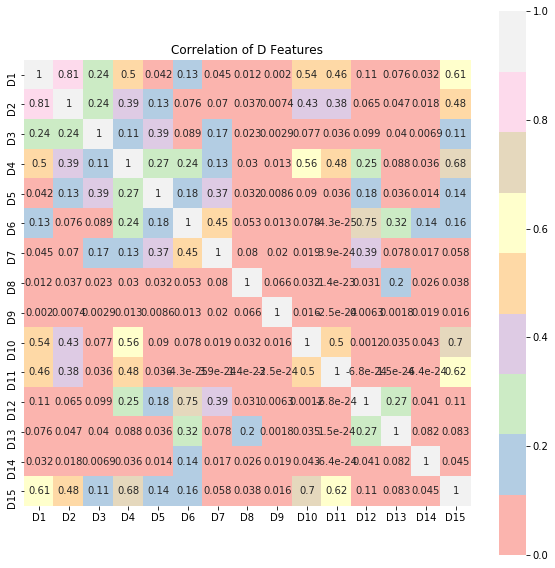

In [40]:
# Review correlation.
d_df = df_train.filter(regex=('^D\d'))

plt.figure(figsize=(10,10))
D_check_corr = d_df.corr()
sns.heatmap(D_check_corr, annot=True, square=True,cmap='Pastel1')
plt.title('Correlation of D Features')

### M1-M9
"match, such as names on card and address, etc." I imputed missing values, but originally some of these variables had almost 50% of missing values.

In [41]:
# Review the variables.
for i in df_train.columns:
    if re.findall(r'^M\d', i):
       # print(i)        
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column M1 are: ['T' 'missing' 'F']
Unique values in column M2 are: ['T' 'missing' 'F']
Unique values in column M3 are: ['T' 'missing' 'F']
Unique values in column M4 are: ['M2' 'M0' 'missing' 'M1']
Unique values in column M5 are: ['F' 'T' 'missing']
Unique values in column M6 are: ['T' 'F' 'missing']
Unique values in column M7 are: ['missing' 'F' 'T']
Unique values in column M8 are: ['missing' 'F' 'T']
Unique values in column M9 are: ['missing' 'F' 'T']


### Vxxx

"Vesta engineered rich features, including ranking, counting, and other entity relations." 

I am working with 339 engineered features with no insight into what these variables are. I'll perform principal component analysis (PCA) to reduce dimensionality with the understanding that this may influence the behavior of the models.

In [42]:
# Review "V" features.
v_df = df_train.filter(regex=('^V\d'))
print(v_df.shape)

# Fill missing values with mean.
for i in v_df.columns:
    v_df[i].fillna(v_df[i].mean(),inplace=True)

(590540, 339)


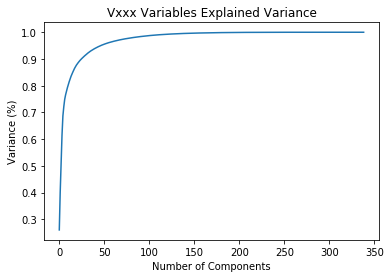

In [43]:
# Standardize data.
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(v_df)
pca = PCA().fit(data_rescaled)

# Plot explained variance.
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Vxxx Variables Explained Variance')
plt.show()

Instead of using 339 variables, I chose to use 25 that explain about 90% of the variance.

In [44]:
# Perform PCA, add new features to the data frame.
pca = PCA(n_components=25)
C_pca = pca.fit_transform(data_rescaled)
principalDf = pd.DataFrame(data = C_pca)

df_train = pd.concat([df_train, principalDf], axis = 1)
df_train = df_train.drop(df_train.filter(regex=('^V\d')),axis=1)

In [45]:
del v_df,principalDf

### DeviceType, DeviceInfo and id

Variables in the identity file are "identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners."

Most of these variables have a lot of missing values. I'll impute data using mean.

In [46]:
# Impute remaining missing values, label encode categorical variables.
encode = LabelEncoder()

for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = encode.fit_transform(df_train[i])
    else:
        df_train[i].fillna(df_train[i].mean(), inplace=True)

In [47]:
# Review the final dataframe.
# # verify there are no mo missing values:
# df_train.isnull().sum()*100/df_train.isnull().count()

# Verify there are only numeric variables.
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 120 entries, TransactionID to 24
dtypes: float64(85), int64(35)
memory usage: 565.2 MB
None


In [48]:
# Export data to a csv file.
df_train.to_csv('clean_data.csv')

## Model Preparation Summary:

I prepared data for modeling by addressing missing values, limiting outliers, and transforming data into numbers. I also reduced some dimensionality - started with 434 variables and currently have 119 features.


# II. Modeling


In [2]:
df_train = df_train.drop('TransactionID', axis=1)

In [3]:
df_train = pd.read_csv('clean_data.csv')
df_train = df_train.drop(['Unnamed: 0','TransactionID'], axis=1)
df_train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,15,16,17,18,19,20,21,22,23,24
0,0,86400,68.5,4,13926,321.0,150.0,1,142.0,1,...,0.000685,-0.029913,-0.005253,0.053531,0.118370,-0.021857,-0.016125,0.023389,0.044807,0.004723
1,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,...,-0.010709,-0.008560,0.001358,0.007942,0.021475,-0.006731,-0.001288,0.011528,0.000929,-0.011356
2,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,...,-0.014290,0.009392,-0.010362,-0.013301,0.002445,-0.013556,-0.004337,0.015820,-0.006693,-0.001044
3,0,86499,50.0,4,18132,567.0,150.0,2,117.0,2,...,0.173052,0.016521,0.003312,-0.058944,0.013206,0.042581,-0.001795,0.003871,0.030996,0.038219
4,0,86506,50.0,1,4497,514.0,150.0,2,102.0,1,...,-0.005919,-0.001307,-0.011223,0.014036,-0.003757,-0.028083,0.247809,0.007666,0.048942,0.035732


In [4]:
# Keep original data frame for SMOTE.
df_train_smote = df_train.copy()

### Train/Test Split

In [5]:
# Split data into train and test sets.
y_train=df_train['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=42)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))


The number of observations in training set is 472432
The number of observations in test set is 118108


## Class Imbalance

To address class imbalance, I'll use Random Undersampling to randomly select samples from the majority class to even it out with the minority class. I'll also train a model after performing the Synthetic Minority Oversampling Technique (SMOTE), where I'll synthetically create samples of the minority class to even it out with the majority class.

### Random Undersampling

In [6]:
# Randomly under sample the majority class.
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 456011, 1: 16421})
Resampled dataset shape Counter({0: 16421, 1: 16421})


## Metrics
For model evaluation, I'll use:

- classification report to review precision, recall and F1 score
- confusion matrix to review false negatives and false positives
- roc_auc_score to review true positive rate and false positive rate

In [7]:
def evaluate(model):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_train_proba = model.predict_proba(X_train)[:,1]
    y_pred_test_proba = model.predict_proba(X_test)[:,1]   
    
    print('Test Classification Report:')
    print(metrics.classification_report(y_test, y_pred_test))
    print('-----------------------------------------------')
    
    print('Test Confusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_pred_test))

    table_test = pd.crosstab(y_test, y_pred_test, margins=True)
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    print('----------------------------------------------')
    
    print((
        'Test Percent Type I errors: {}\n'
        'Test Percent Type II errors: {}'
    ).format(test_tI_errors, test_tII_errors))
    print('---------------------------------------------')
    # ROC curve
    fpr1, tpr1, _ = metrics.roc_curve(y_train, y_pred_train_proba)
    auc1 = metrics.roc_auc_score(y_train, y_pred_train_proba)

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_test_proba)

    print('Train ROC AUC:',auc1)
    print('Test ROC AUC:',auc)

    fig, ax = plt.subplots()
    ax.plot(fpr1, tpr1, label='roc_auc_train='+str(auc1))
    ax.plot(fpr, tpr, label='roc_auc_test='+str(auc))

    plt.legend(loc=4)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Models

I'll work with Decision Tree and ensemble models such as Random Forest and Gradient Boosting Classifier to select and tune the best model.

## Decision Tree

In [8]:
features = df_train.drop('isFraud', axis=1).columns

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    113866
           1       0.10      0.45      0.16      4242

    accuracy                           0.83    118108
   macro avg       0.54      0.65      0.53    118108
weighted avg       0.94      0.83      0.88    118108

-----------------------------------------------
Test Confusion Matrix:
[[96432 17434]
 [ 2349  1893]]
----------------------------------------------
Test Percent Type I errors: 0.14761066142852305
Test Percent Type II errors: 0.01988857655704948
---------------------------------------------
Train ROC AUC: 0.6947492186710811
Test ROC AUC: 0.6963328216853292


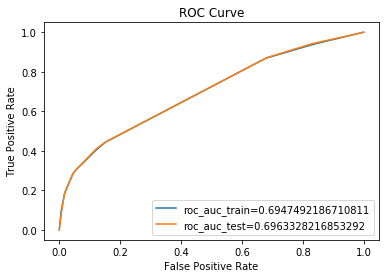

In [9]:
# Train a decision tree model.
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
dt = dt.fit(X_train,y_train)

# Evaluate.
evaluate(dt)

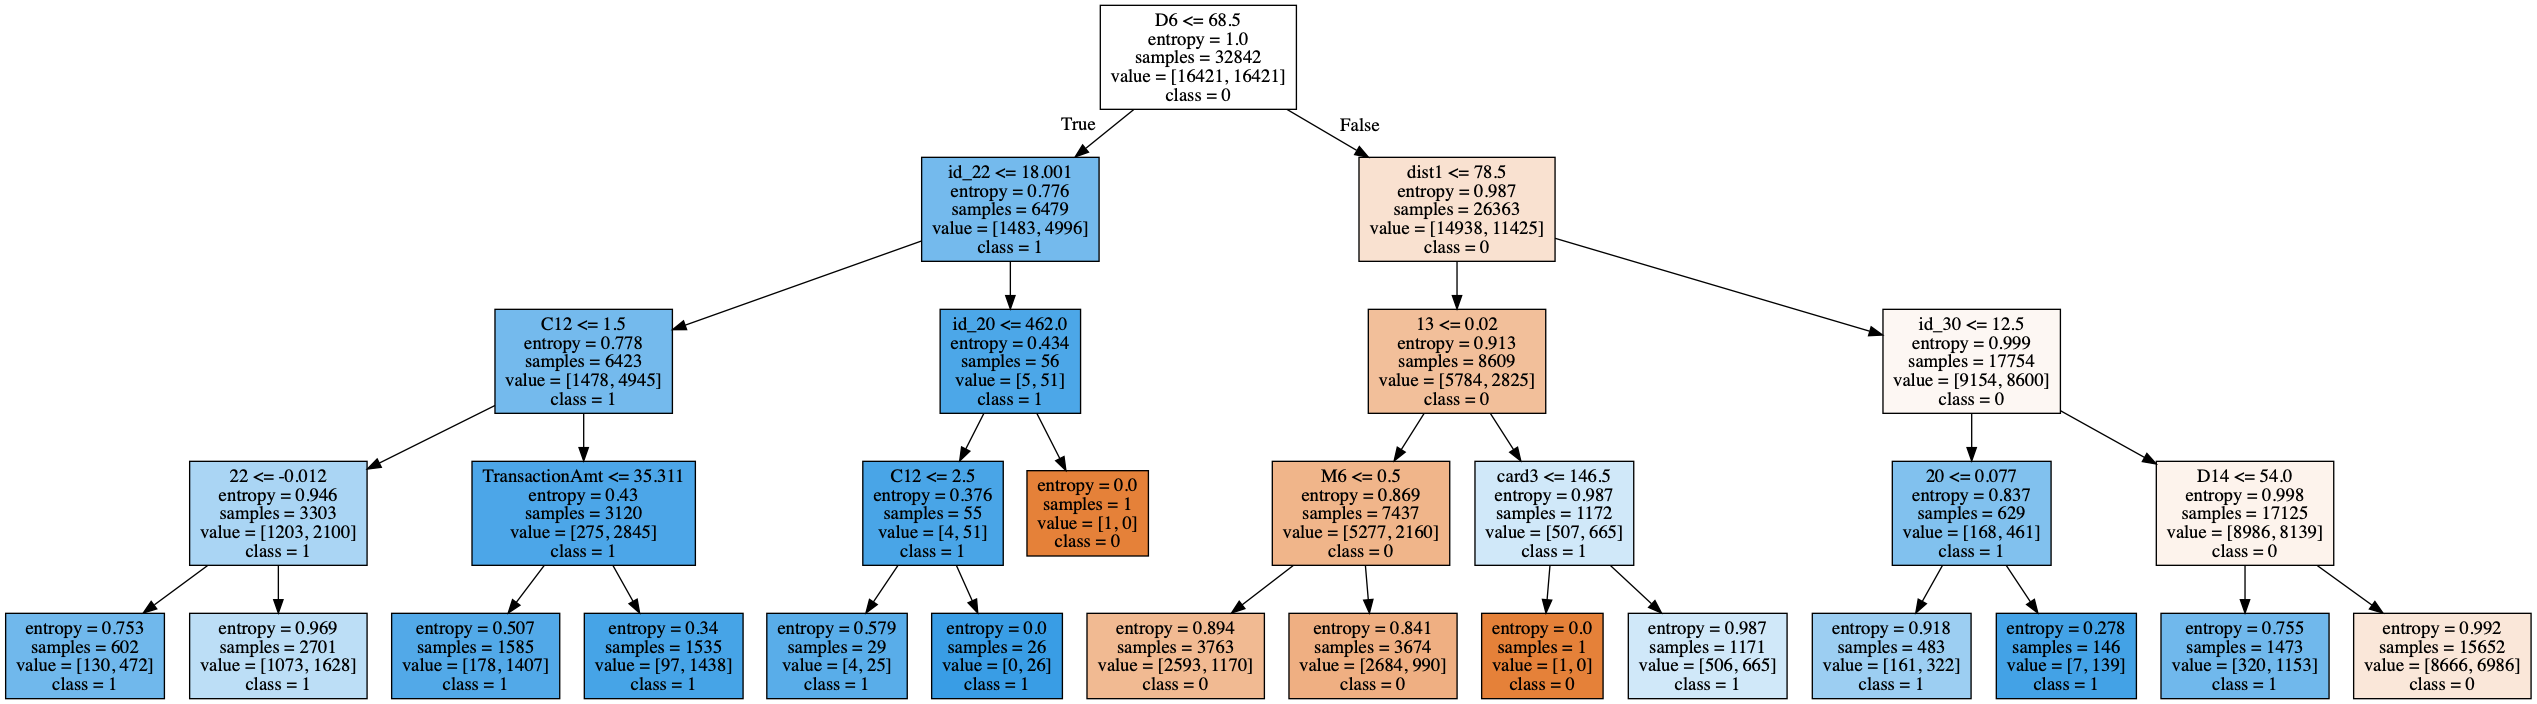

In [10]:
# Render the tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=features,
    class_names=['0', '1'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Random Forest

Random Forest with 100 trees.

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113866
           1       0.21      0.84      0.33      4242

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Test Confusion Matrix:
[[100237  13629]
 [   673   3569]]
----------------------------------------------
Test Percent Type I errors: 0.11539438480035222
Test Percent Type II errors: 0.0056981745521048534
---------------------------------------------
Train ROC AUC: 0.9999999999999999
Test ROC AUC: 0.9308580181094609


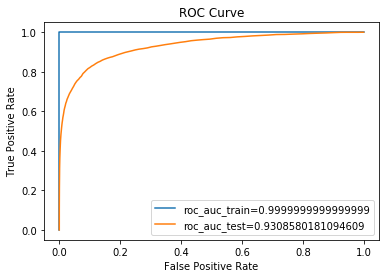

In [11]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

evaluate(rfc)

In [12]:
# Review important features.
feature_list = list(df_train.drop('isFraud',axis=1).columns)

importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 1                    Importance: 0.04
Variable: TransactionDT        Importance: 0.03
Variable: TransactionAmt       Importance: 0.03
Variable: C13                  Importance: 0.03
Variable: C14                  Importance: 0.03
Variable: card1                Importance: 0.02
Variable: card2                Importance: 0.02
Variable: addr1                Importance: 0.02
Variable: C1                   Importance: 0.02
Variable: C4                   Importance: 0.02
Variable: C5                   Importance: 0.02
Variable: D2                   Importance: 0.02
Variable: D3                   Importance: 0.02
Variable: D8                   Importance: 0.02
Variable: 7                    Importance: 0.02
Variable: 9                    Importance: 0.02
Variable: 11                   Importance: 0.02
Variable: 17                   Importance: 0.02
Variable: ProductCD            Importance: 0.01
Variable: card3                Importance: 0.01
Variable: card4                Importanc

### Hyperparameters Tuning

In [13]:
# Review the hyperparameters of the Random Forest model.
pprint(rfc.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


I'll tune:

- n_estimators -- the number of trees in the forest
- max_features -- the number of features to consider when looking for the best split
- max_depth  -- max number of levels in each decision tree
- criterion -- gini or entropy to measure the quality of a split

In [14]:
# Create parameter grid.
param_grid = {
    'max_depth': [None, 80, 100],
    'max_features': ['auto', 4],
    'n_estimators': [100, 300, 1000],
    'criterion':['gini','entropy']
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [16]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 27.8min finished


{'criterion': 'entropy',
 'max_depth': 80,
 'max_features': 'auto',
 'n_estimators': 1000}

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113866
           1       0.21      0.84      0.34      4242

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.64    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Test Confusion Matrix:
[[100488  13378]
 [   667   3575]]
----------------------------------------------
Test Percent Type I errors: 0.11326921123039929
Test Percent Type II errors: 0.005647373590273309
---------------------------------------------
Train ROC AUC: 0.9999999999999999
Test ROC AUC: 0.9348009556432633


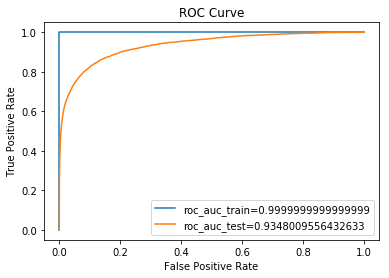

In [17]:
# Train random forest with best parameters.
rfc4 = RandomForestClassifier(criterion='entropy',
                             max_depth=80,
                             max_features='auto',
                             n_estimators=1000)

rfc4.fit(X_train, y_train)

# Evaluate.
evaluate(rfc4)

This model did slightly better than the original model with 100 trees. But the model is still overfitting.

## Gradient Boosting Classifier

Gradient Boosting classifier with 100 trees each of which can go two levels deep.

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113866
           1       0.14      0.77      0.24      4242

    accuracy                           0.83    118108
   macro avg       0.57      0.80      0.57    118108
weighted avg       0.96      0.83      0.88    118108

-----------------------------------------------
Test Confusion Matrix:
[[94526 19340]
 [  993  3249]]
----------------------------------------------
Test Percent Type I errors: 0.1637484336370102
Test Percent Type II errors: 0.008407559183120535
---------------------------------------------
Train ROC AUC: 0.8781784777951591
Test ROC AUC: 0.8763042929034768


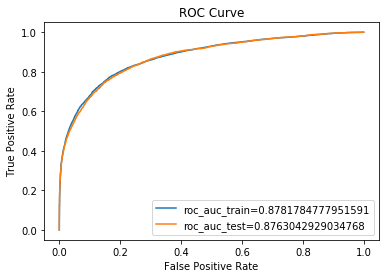

In [18]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=100,
                                          max_depth=2,
                                          loss='deviance')
gbc.fit(X_train, y_train)

evaluate(gbc)

In [19]:
# Review important features.
feature_list = list(df_train.drop('isFraud',axis=1).columns)

importances = list(gbc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 1                    Importance: 0.16
Variable: C14                  Importance: 0.11
Variable: C4                   Importance: 0.08
Variable: C1                   Importance: 0.07
Variable: D3                   Importance: 0.05
Variable: id_17                Importance: 0.05
Variable: card6                Importance: 0.04
Variable: C8                   Importance: 0.04
Variable: C11                  Importance: 0.03
Variable: D2                   Importance: 0.03
Variable: 7                    Importance: 0.03
Variable: 11                   Importance: 0.03
Variable: TransactionAmt       Importance: 0.02
Variable: C5                   Importance: 0.02
Variable: C13                  Importance: 0.02
Variable: D5                   Importance: 0.02
Variable: D8                   Importance: 0.02
Variable: M4                   Importance: 0.02
Variable: 4                    Importance: 0.02
Variable: TransactionDT        Importance: 0.01
Variable: R_emaildomain        Importanc

### Synthetic Minority Oversampling Technique (SMOTE)
Let's now perform SMOTE on our test data and train a random forest model with 100 trees.

In [20]:
# Split and under sample majority in original data.
y_train=df_train_smote['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train_smote.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=42)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

# use SMOTE:
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(ratio='minority',random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 456011, 1: 16421})
Resampled dataset shape Counter({0: 456011, 1: 456011})


Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.92      0.55      0.69      4242

    accuracy                           0.98    118108
   macro avg       0.95      0.77      0.84    118108
weighted avg       0.98      0.98      0.98    118108

-----------------------------------------------
Test Confusion Matrix:
[[113675    191]
 [  1920   2322]]
----------------------------------------------
Test Percent Type I errors: 0.0016171639516374843
Test Percent Type II errors: 0.016256307786094083
---------------------------------------------
Train ROC AUC: 1.0
Test ROC AUC: 0.9306615240013504


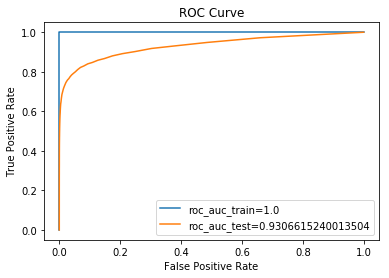

In [21]:
# Random Forest.
rfcs = RandomForestClassifier(n_estimators=100)
rfcs.fit(X_train, y_train)

evaluate(rfcs)

In [22]:
# review hyperparameters of the model:
pprint(rfcs.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [23]:
# create parameter grid:
param_grid = {
    'max_depth': [None, 80, 100],
    'max_features': ['auto', 4],
    'n_estimators': [100, 300, 1000],
    'criterion':['gini','entropy']
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfcs, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(Note: not enough memory on my computer to perform grid search validation on this data.)

## Summary

Below is the summary performance of the models, which includes ROC AUC scores and precision and recall scores for identifying fraudulent transactions:

|Model	              |ROC AUC	|Precision| Recall |
|---------------------|----------|---------|--------|
|Decision Tree	      |0.6963	|0.10	  |0.45    |
|Gradient Boosting	  |0.8763	|0.14	  |0.77    |
|Random Forest (1000) |0.9348	|0.21	  |0.84    |
|Random Forest (SMOTE)|0.9306	|0.92	  |0.55    |

Random Forest Classifiers have the highest ROC AUC score.

When the cost of false negatives is high, Random Forest (1000) is the best model (Recall=0.84). When the cost of false positives is high, Random Forest (SMOTE) is the best model (Precision=0.92)

### Next Steps:

Experiment with additional feature selection and engineering, use big data technologies to train and tune models.